### Imports & Custom Built, Generic Functions

In [1]:
import pandas as pd
from bs4 import BeautifulSoup 
import unidecode
import collections
from django.utils.encoding import smart_str, smart_unicode
import re
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.figure as fig

In [2]:
def double_digit(orig):
    if len(orig)<2:
        return(double_digit('0'+orig))
    else:
        return(orig)

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def convertU(data):
    if isinstance(data, basestring):
        return smart_str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convertU, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convertU, data))
    else:
        return data

## Extract from iOS

In [3]:
def get_ratings(soup):
    rating_spans = soup.find_all("span",{"class":"rating-count"})
    ratings = []
    for span in rating_spans:
        ratings.append(int(re.findall('\d+', cleanhtml(str(span)))[0]))
    if len(ratings)==1:
        return(0,ratings[0])  
    elif ratings[0]<ratings[1]:
        return(ratings[0],ratings[1])
    else:
        return(ratings[1],ratings[0])

def get_size(soup):
    size_lis = soup.find_all("li")
    for li in size_lis:
        li_spans= li.find_all("span",{"class":"label"})
        if len(li_spans) >0:
            if "Size" in cleanhtml(str(li_spans)):
                return(int(re.findall('\d+', cleanhtml(str(li)))[0]))

def get_description(soup):
    desc_ps = soup.find_all("p",{"itemprop":"description"})
    return(cleanhtml(str(desc_ps[0])))

def get_version(soup):
    vers_spans = soup.find_all("span",{"itemprop":"softwareVersion"})
    return(cleanhtml(str(vers_spans[0])))

In [52]:
ios_df = pd.DataFrame(columns = ['dtg','curr_ratings','tot_ratings','size','desc','ver'])
ios_eod = pd.DataFrame(columns = ['dtg','curr_rating','tot_rating','size'])

row = 0
day = 0 
for mo in range(7,11):
    for da in range(1,32):
        for hr in range(0,24):
            for mn in range(0,60,10):
                try:
                    soup = BeautifulSoup(open("C:\\Users\\ajwil\\OneDrive\\Documents\\00_public\\00_Pokemon_Go_Project\\data\\2016-{}-{}\\{}_{}_pokemon_ios.html".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn)))), "lxml")

                    ios_df.loc[row]=[datetime.strptime("2016-{}-{}.{}:{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))),'%Y-%m-%d.%H:%M'),
                                     get_ratings(soup)[0],
                                     get_ratings(soup)[1],
                                     get_size(soup),
                                     get_description(soup),
                                     get_version(soup)]
                    row+=1
                    if "{}_{}".format(double_digit(str(hr)),double_digit(str(mn))) == "23_50":
                        ios_eod.loc[day]=[datetime.strptime("2016-{}-{}.{}:{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))),'%Y-%m-%d.%H:%M'),
                                          get_ratings(soup)[0],
                                          get_ratings(soup)[1],
                                          get_size(soup)]
                        day+=1                        
                except:
                    #print("Did not complete for 2016-{}-{}.{}-{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))))
                    continue
print(row)
print(day)

14810
103


### iOS Data Visualizations

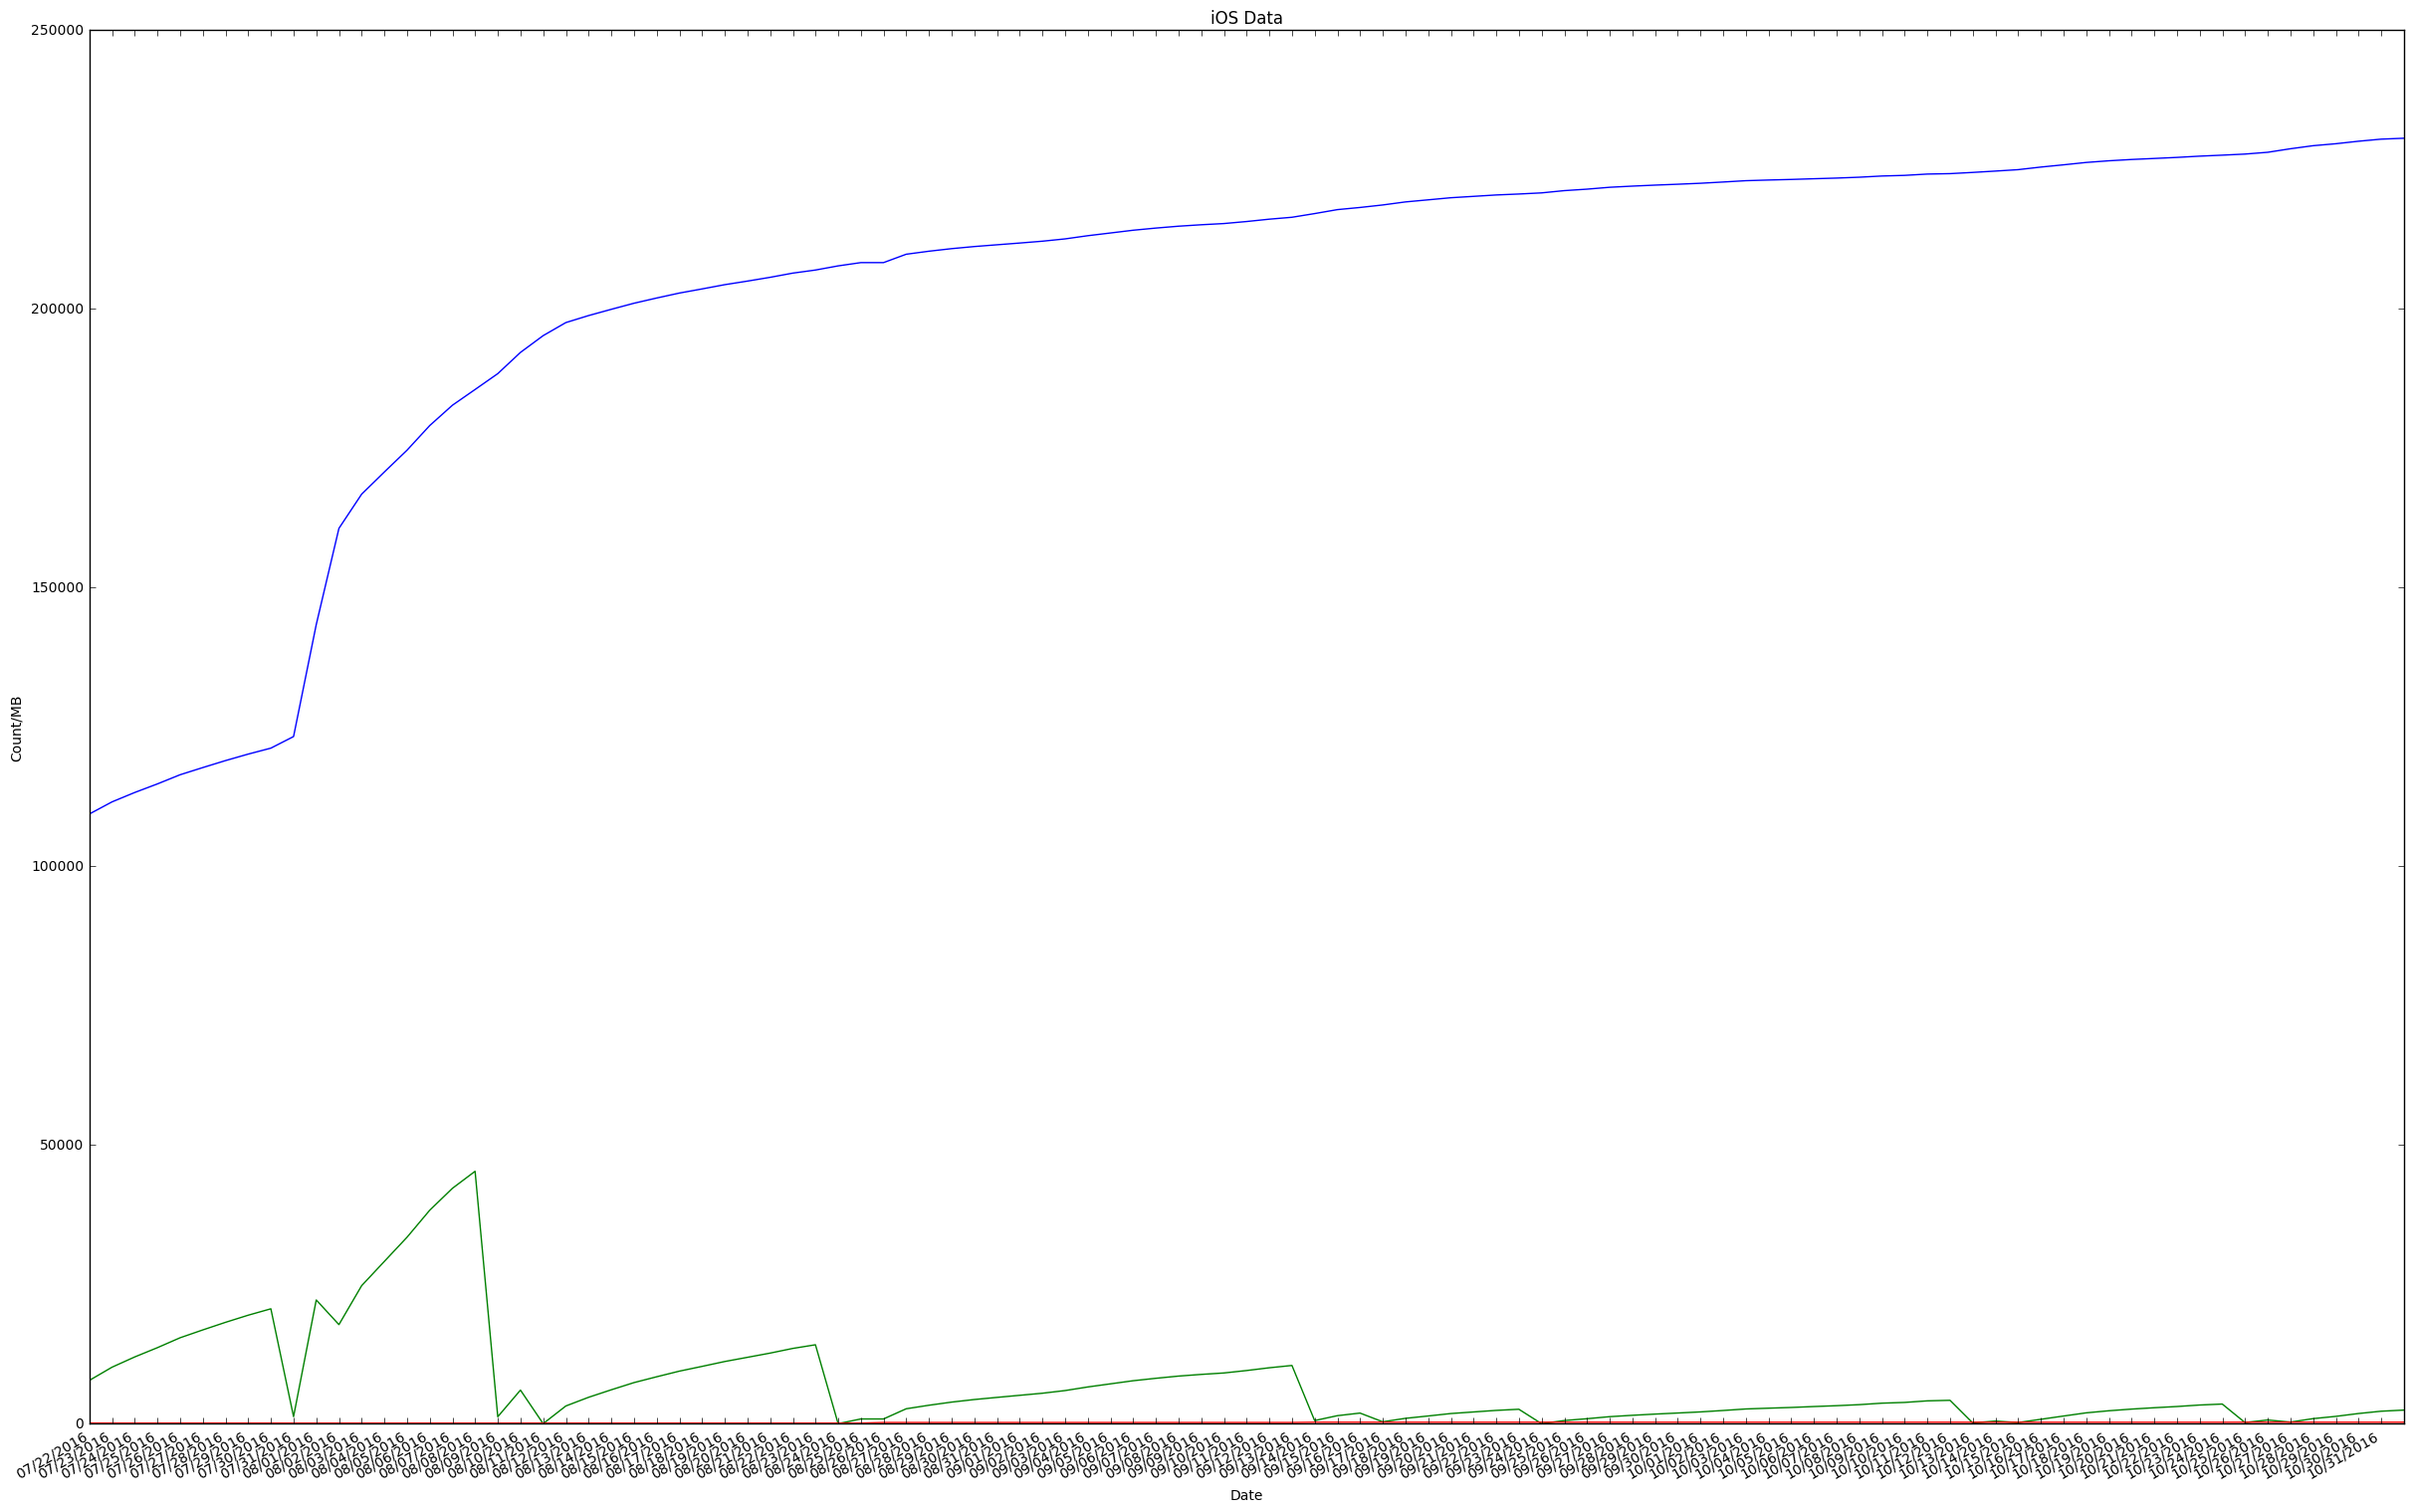

In [79]:
plt.subplots(figsize=(30,20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(ios_eod['dtg'],ios_eod['tot_rating'])
plt.plot(ios_eod['dtg'],ios_eod['curr_rating'])
plt.plot(ios_eod['dtg'],ios_eod['size'])
plt.xlabel('Date')
plt.ylabel('Count/MB')
plt.title('iOS Data')
plt.gcf().autofmt_xdate()

plt.savefig('iOS.png', dpi = 400)
plt.show()


In [ ]:
#matplotlib
#plt.plot(x,y)
#plt.scatter(x,y, s=size in nparray, c=color dict, alpha = 1.0)
#plt.xscale('log') #change xscale
#plt.show() #display plot
#plt.hist(x,bins=10)
#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('title')
#plt.yticks([*list of tics],[*list of tic titles])

## Extract from Android

In [4]:
def get_avg_android_score(soup):
    divs = soup.find_all("div",{"class":"score"})
    return(float(cleanhtml(str(divs[0]))))

def get_android_ratings(soup):
    hist_divs = soup.find_all("div",{"class":"rating-histogram"})
    scores = []
    for div in hist_divs:
        div_spans= div.find_all("span",{"class":"bar-number"})
        for div in div_spans:
            scores.append(int(cleanhtml(str(div)).replace(',','')))
    return(scores[4],scores[3],scores[2],scores[1],scores[0])

def get_total_android_ratings(soup):
    spans = soup.find_all("span",{"class":"reviews-num"})
    return(int(cleanhtml(str(spans[0])).replace(',','')))

def get_android_size(soup):
    divs = soup.find_all('div',{"itemprop":"fileSize"})
    return(int(re.findall('\d+',cleanhtml(str(divs[0])))[0]))

def get_android_version(soup):
    divs = soup.find_all('div',{"itemprop":"softwareVersion"})
    return(cleanhtml(str(divs[0])))

def get_android_desc(soup):
    divs = soup.find_all('div',{"itemprop":"description"})
    return(cleanhtml(str(divs[0])))
#soup = BeautifulSoup(open("C:\\Users\\ajwil\\OneDrive\\Documents\\00_public\\00_Pokemon_Go_Project\\data\\2016-{}-{}\\{}_{}_pokemon_android.html".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn)))), "lxml")
#print(get_android_ratings(soup))

In [ ]:
and_df = pd.DataFrame(columns = ['dtg',
                                 'avg_score',
                                 'total_ratings',
                                 'one_star',
                                 'two_star',
                                 'three_star',
                                 'four_star',
                                 'five_star',
                                 'size',
                                 'version',
                                 'desc'])
and_eod = pd.DataFrame(columns = ['dtg',
                                  'avg_score',
                                  'total_ratings',
                                  'one_star',
                                 'two_star',
                                 'three_star',
                                 'four_star',
                                 'five_star',
                                 'size',
                                 'version',
                                 'desc'])
row = 0
day = 0 
for mo in range(7,11):
    for da in range(1,32):
        for hr in range(0,24):
            for mn in range(0,60,10):
                try:
                    soup = BeautifulSoup(open("C:\\Users\\ajwil\\OneDrive\\Documents\\00_public\\00_Pokemon_Go_Project\\data\\2016-{}-{}\\{}_{}_pokemon_android.html".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn)))), "lxml")
                    temp_scores = get_android_ratings(soup)

                    and_df.loc[row]=[datetime.strptime("2016-{}-{}.{}:{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))),'%Y-%m-%d.%H:%M'),
                                    get_avg_android_score(soup),
                                    get_total_android_ratings(soup),
                                    temp_scores[0],
                                    temp_scores[1],
                                    temp_scores[2],
                                    temp_scores[3],
                                    temp_scores[4],
                                    get_android_size(soup),
                                    get_android_version(soup),
                                    get_android_desc(soup)]
                    row+=1
                    if "{}_{}".format(double_digit(str(hr)),double_digit(str(mn))) == "23_50":
                        
                        and_eod.loc[day]=[datetime.strptime("2016-{}-{}.{}:{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))),'%Y-%m-%d.%H:%M'),
                                        get_avg_android_score(soup),
                                        get_total_android_ratings(soup),
                                        temp_scores[0],
                                        temp_scores[1],
                                        temp_scores[2],
                                        temp_scores[3],
                                        temp_scores[4],
                                        get_android_size(soup),
                                        get_android_version(soup),
                                        get_android_desc(soup)]
                        day+=1                        
                except:
                    print("Did not complete for 2016-{}-{}.{}-{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))))
                    continue
print(row)
print(day)

Did not complete for 2016-07-01.00-00
Did not complete for 2016-07-01.00-10
Did not complete for 2016-07-01.00-20
Did not complete for 2016-07-01.00-30
Did not complete for 2016-07-01.00-40
Did not complete for 2016-07-01.00-50
Did not complete for 2016-07-01.01-00
Did not complete for 2016-07-01.01-10
Did not complete for 2016-07-01.01-20
Did not complete for 2016-07-01.01-30
Did not complete for 2016-07-01.01-40
Did not complete for 2016-07-01.01-50
Did not complete for 2016-07-01.02-00
Did not complete for 2016-07-01.02-10
Did not complete for 2016-07-01.02-20
Did not complete for 2016-07-01.02-30
Did not complete for 2016-07-01.02-40
Did not complete for 2016-07-01.02-50
Did not complete for 2016-07-01.03-00
Did not complete for 2016-07-01.03-10
Did not complete for 2016-07-01.03-20
Did not complete for 2016-07-01.03-30
Did not complete for 2016-07-01.03-40
Did not complete for 2016-07-01.03-50
Did not complete for 2016-07-01.04-00
Did not complete for 2016-07-01.04-10
Did not comp